In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
plt.rc("axes.spines", top=False, right=False)
sns.set_context("paper")
%matplotlib inline

http://www.jtrive.com/loess-nonparametric-scatterplot-smoothing-in-python.html

LOWESS (or also referred to as LOESS for *locally-weighted scatterplot smoothing*) is a non-parameteric regression method for smoothing data. 

The "non-parametric"-ness of the method refers to the fact that unlike linear or non-linear regression, the model can't be parameterised -- we can't write the model as the sum of several parametric terms such as with linear regression:

$$ y = \beta_0 + \beta_1 x$$

Instead LOWESS attempts to fit a linear model for each observation based on nearby (or *local*) observations. This makes the method more versatile than fitting some n-order polynomial to wiggly data but of course means that we do not have global parameters such as $\beta_0$ and $\beta_1$ with which to test hypotheses. 


To start looking at LOWESS methods, let's create some nonsense data which has some interesting nonmontonic reponse and plot it.

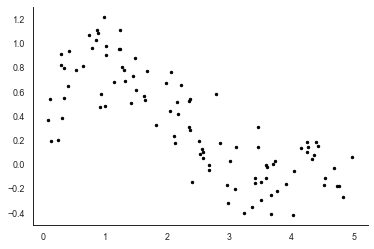

In [10]:
x = 5*np.random.random(100)
y = np.sin(x) * 3*np.exp(-x) + np.random.normal(0, 0.2, 100)
plt.plot(x, y, 'k.')

# statsmodels

Python package statsmodels has an efficent LOWESS smoother built in which provides the obvious choice for doing a lowess smoother in python:

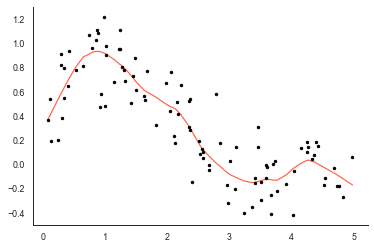

In [11]:
from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess
sm_x, sm_y = sm_lowess(y, x,  frac=1./5., 
                           it=5, return_sorted = True).T
plt.plot(sm_x, sm_y, color='tomato')
plt.plot(x, y, 'k.')

So that looks fairly sensible, `sm_lowess` has picked out the main structure in the data but not overfitted the curve to any of the noise in the data. 

Of course judging the quality of the fit is difficult because we don't really have an idea of the uncertainty. Ideally we'd have a LOWESS method which provides us some confidence interval on the fit of the model so we can see which individual observations are within the fit and those outside of the fitted curve. 


# Bootstrapping

- Principles of bootstrapping



In [4]:
import scipy.interpolate

def smooth(x, y, xgrid):
    samples = np.random.choice(len(x), 50, replace=True)
    y_s = y[samples]
    x_s = x[samples]
    y_sm = sm_lowess(y_s,x_s, frac=1./5., it=5,
                     return_sorted = False)
    # regularly sample it onto the grid
    y_grid = scipy.interpolate.interp1d(x_s, y_sm, 
                                        fill_value='extrapolate')(xgrid)
    return y_grid


So `smooth` samples 50% of the observations and fits the lowess model. Also because statsmodels doest not provide the solution on an interpolated, and we're randomly sampling each, the solution is interpolated to the same 1d grid each time specified with `xgrid`.  Let's run `smooth` 100 times and plot each lowess solution:

/Users/janetbrennan/miniconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


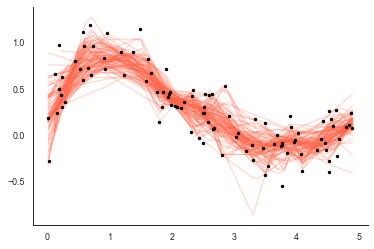

In [5]:
xgrid = np.linspace(x.min(),x.max())
K = 100
smooths = np.stack([smooth(x, y, xgrid) for k in range(K)]).T
plt.plot(xgrid, smooths, color='tomato', alpha=0.25)
plt.plot(x, y, 'k.')

We can then use the individual fits to provide the mean and standard error of the LOWESS model:

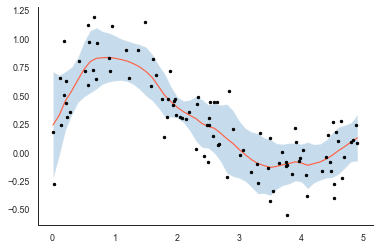

In [6]:
mean = np.nanmean(smooths, axis=1)
stderr = scipy.stats.sem(smooths, axis=1)
stderr = np.nanstd(smooths, axis=1, ddof=0)
# plot it
plt.fill_between(xgrid, mean-1.96*stderr,
                     mean+1.96*stderr, alpha=0.25)
plt.plot(xgrid, mean, color='tomato')
plt.plot(x, y, 'k.')

The 95% confidence interval (shaded blue) seems fairly sensible -- the uncertainty increases when observations nearby have a large spread (at around x=2) but also at the edges of the plot where the number of observations tends towards zero (at the very edge we only have observations from the left or right to do the smoothing). 

Simiarly, because bootstrapping provides draws from the posterior of the lowess smooth we can create a true confidence interval from any percentiles: 

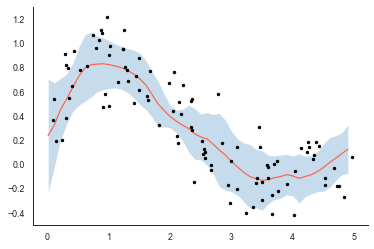

In [33]:
mean = np.nanmean(smooths, axis=1)
c25 = np.nanpercentile(smooths, 2.5, axis=1) #2.5 percent
c97 = np.nanpercentile(smooths, 97.5, axis=1) # 97.5 percent
# a 95% confidence interval
plt.fill_between(xgrid, mean-1.96*stderr,
                     mean+1.96*stderr, alpha=0.25)
plt.plot(xgrid, mean, color='tomato')
plt.plot(x, y, 'k.')

# Writing a custom LOWESS smoother

Notice the simialirity in the mean+std confidence interval and the percentile based confidence interval. Actually under certain assumptions, these should be the same because of the way LOWESS works. 


To understand how the LOWESS smoother works a little more lets delve deeper. 
Cleveland (1979) first introduced the LOWESS smoother, ad

LOWESS smoothers are 


- Text about how lowess smoothing works
- just a linear model so we can get confidence intervals

Cleveland (1979) first introduced the lowess smoother and the framework for providing confidence intervals is included. 

The lowess smoother is just another type of kernel smoother 


We can understand this a bit more clearly by estimating the curve locally for a couple of observations:

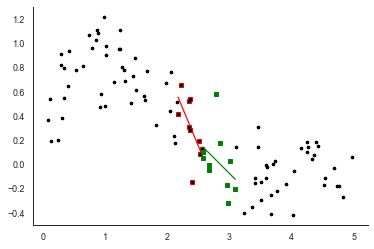

In [27]:
import scipy.stats
order = np.argsort(x) # order the points
k = 50
xx = x[order][k-5:k+5]
yy = y[order][k-5:k+5]
plt.plot(x, y, 'k.')
plt.plot(xx, yy, 'rs')
res = scipy.stats.linregress(xx, yy)
plt.plot(xx, res.intercept + res.slope *xx, 'r-')
k = 60
xx = x[order][k-5:k+5]
yy = y[order][k-5:k+5]
plt.plot(x, y, 'k.')
plt.plot(xx, yy, 'gs')
res = scipy.stats.linregress(xx, yy)
plt.plot(xx, res.intercept + res.slope *xx, 'g-')

Extending this principle we can get something looks a bit like the fit from earlier:

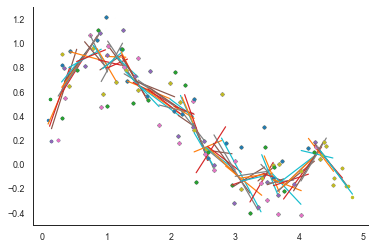

In [32]:
order = np.argsort(x)
for k in range(5, len(y)-5 ):
    xx = x[order][k-5:k+5]
    yy = y[order][k-5:k+5]
    plt.plot(xx, yy, '.')
    res = scipy.stats.linregress(xx, yy)
    plt.plot(xx, res.intercept + res.slope *xx, '-')

Instead of just selecting the 5 nearest data points and fitting a simple linear regression, LOWESS weights the points based on distance. 

This is what specifies LOWESS smoothing as just another kernel smoother method. 

With kernel smoothing the infleunce of nearby points is determined by the kernel function $F$ and alters the weighting of the regression fit. 



The tricube function is the classic kernel function for lowess smoothers: 


Text(0, 0.5, '(1 - np.abs(d)**3)**3')

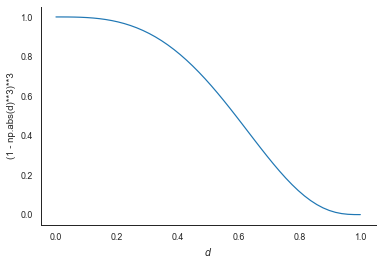

In [36]:
tricube = lambda d : (1 - np.abs(d)**3)**3
d = np.linspace(0,1)
plt.plot(d, tricube(d))
plt.xlabel("$d$")
plt.ylabel("(1 - np.abs(d)**3)**3")


Let's specify what we have a bit more clearly, two vectors providing the x and y observations:

$$x = [x_1 \cdots x_N]$$
$$y =  [y_1 \cdots y_N]$$

For observation $x_i$ , the LOWESS fitting starts with calculating the distance between $x_i$ and each other observation $x_j$ provides:

$$d_{ij} =  [y_{i0} \cdots y_{iN}]$$



With these distances, the tri-cube  weighting function is used to up-weight observations which are more local:

$$ w_i = (1 - |d_{ij}|^3)^3  $$


With $w$ we solve a standard weighted least squares system:

$$ \hat{\beta} = \left(\mathbf{X}^T \mathbf{W}  \mathbf{X} \right)^{-1} \mathbf{X}^T \mathbf{W} y $$

where $\mathbf{X}$ is for a first-order LOWESS:

$$ \mathbf{X} = \begin{bmatrix}
1 &  x_1\\ 
\vdots &\vdots  \\ 
1 &  x_N
\end{bmatrix}$$

which is a linear model with an intercept (1 values) and the slope. $\mathbf{W}$ is just a diagonal matrix formed from $w_i$:

$$\mathbf{W} = \begin{bmatrix}
w_1 &  & \\ 
 & \ddots & \\ 
 &  & w_N
\end{bmatrix}$$

Solving the system provides $\hat{\beta}$ - the intercept $\beta_0$ and slope $\beta_1$. The LOWESS smoothed observation $\hat{y}_{sm}$ is providing from using the row of the system corresponding to $i$:

$$ \hat{y}_{sm} = \mathbf{X}_i \hat{\beta}  $$


So algorithmically we loop over each observation $i$ update the $\mathbf{W}$ with the new weights and resolve the system to update $\hat{\beta}$. 

## Confidence intervals for LOWESS


Because the LOWESS smoother for any individual prediction is essentially weighted linear least squares, the propagation of uncertainty principles are well understood. With any linear model (with normal errors in the observations $y$) the uncertainty in the parameters $var(\hat{\beta})$ are provided from the posterior covariance matrix which is:

$$\sigma^2\left(\mathbf{X}^T  \mathbf{X}\right)^{-1}$$

The diagonal of this matrix provides $var(\hat{\beta})$:

$$ var(\hat{\beta}) = \text{diag} \left[ \sigma^2 \left(\mathbf{X}^T  \mathbf{X}\right)^{-1} \right] $$


$\sigma^2$ is important -- it is our estimate of the uncertainty in the initial observations. For this approach to work, we assume that observations have an error model of the form:

$$ y = y_{true} + \mathcal{N}(0, \sigma^2) $$

The variance $\sigma^2$ provides an indication of the spread in the observations away from our model of the observations:

$$ \hat{y}_sm = f(x) + \epsilon$$

where $f(x)$ is the LOWESS smoothing model and $\epsilon$ is the error arising in the prediction because of the observations. In some cases we know what $\sigma^2$ is, but often we don't. One option to estimate $\sigma^2$ is to assume that our model is perfect and the residuals between the model and observations $\hat{y}_{sm}-y$ provides a good measure. The root mean square error (RMSE) provides often a good estimate of $\sigma$:

$$ \sigma = \sqrt{\frac{\sum_i^{N}( \hat{y}_{sm} - y_i  )^2}{N}} $$


With an estimate of $\sigma$ we can then estimate $var(\hat{\beta})$ correctly and provide a confidence interval based on the assumption that the uncertainty in the parameters is normally distributed:

$$ \text{CI}_{0.95} = \hat{\beta_1} \pm 1.96 \sqrt{var(\hat{\beta_1}) } $$


So we've now got a way to get the confidence interval in parameters from the variance $var(\hat{\beta})$ but we really want the confidence interval for the fitted curve $\hat{y}_sm$. 


To get this remember that $\hat{y}_sm$ is provided by:

$$ \hat{y}_{sm} = \mathbf{X}_i \hat{\beta} $$

So we want the variance $var(\hat{y}_{sm})$, which is:

The variance of the prediction $var( \hat{y}_{sm})$ 

$$ var(\hat{y}_{sm}) = var(\mathbf{X}_i \hat{\beta}) = \mathbf{X}_i^T \sigma^2 \left(\mathbf{X}^T  \mathbf{X}\right)^{-1} \mathbf{X}_i$$


Code wise this relatively simple to implement

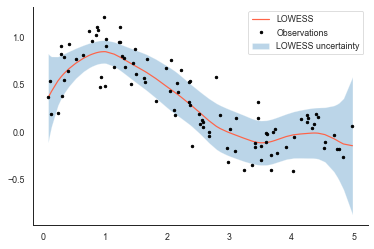

In [79]:
def lowess(x, y, f=1./3.):
    """
    Basic LOWESS smoother with uncertainty. 
    Note:
        - Not robust (so no iteration) and only normally distributed errors. 
        - No higher order polynomials d=1 so linear smoother.
    """
    # get some paras
    xwidth = f*(x.max()-x.min()) # effective width after reduction factor
    N = len(x) # number of obs
    # Don't assume the data is sorted
    order = np.argsort(x)
    # storage
    y_sm = np.zeros_like(y)
    y_stderr = np.zeros_like(y)
    # define the weigthing function -- clipping too!
    tricube = lambda d : np.clip((1- np.abs(d)**3)**3, 0, 1)
    # run the regression for each observation i
    for i in range(N):
        dist = np.abs((x[order][i]-x[order]))/xwidth
        w = tricube(dist)
        # form linear system with the weights
        A = np.stack([w, x[order]*w]).T
        b = w * y[order]
        ATA = A.T.dot(A)
        ATb = A.T.dot(b)
        # solve the syste
        sol = np.linalg.solve(ATA, ATb)
        # predict for the observation only
        yest = A[i].dot(sol)# equiv of A.dot(yest) just for k
        place = order[i]
        y_sm[place]=yest 
        sigma2 = (np.sum((A.dot(sol) -y [order])**2)/N )
        # Calculate the standard error
        y_stderr[place] = np.sqrt(sigma2 * A[i].dot(np.linalg.inv(ATA)).dot(A[i]))
    return y_sm, y_stderr

#run it
y_sm, y_std = lowess(x, y, f=1./5.)
# plot it
plt.plot(x[order], y_sm[order], color='tomato', label='LOWESS')
plt.fill_between(x[order], y_sm[order] - 1.96*y_std[order],
                 y_sm[order] + 1.96*y_std[order], alpha=0.3, label='LOWESS uncertainty')
plt.plot(x, y, 'k.', label='Observations')
plt.legend(loc='best')